In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import acessos as ac
import os 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
text_file = open(os.path.abspath('../Elasticidade CR - Simulações/sql/jan23_ComESemAtendimento.sql'), "r")
query = text_file.read()
text_file.close()
df = ac.df_athena_q('flavia-costa', query)

In [ ]:
len(df)

175227

In [5]:
df.usou_chat.value_counts()

2023-01-01    48173
2023-02-01    43292
2023-03-01    41002
Name: dt_mes_true, dtype: int64

In [6]:
missing_zero = ['qt_compra_antes_90d', 'vl_compra_antes_90d', 'vl_compra_depois_60d', 'spending_ltv', 'ltv', 'dias_atraso_ltv', 'rec_itr',
					'rec_recarga', 'rec_demais_encargos', 'desp_pdd', 'rec_juros', 'custos']

for column in missing_zero:
    df[column].fillna(0, inplace = True)

In [7]:
len(df.query('vl_compra_antes_90d == 0'))

42760

In [8]:
len(df.query('vl_compra_depois_60d == 0'))

61203

Criação de variáveis

In [9]:
df['dt_opening_account'] = pd.to_datetime(df['dt_opening_account'], format='%Y-%m-%d')
df['dt_mes_true'] = pd.to_datetime(df['dt_mes_true'], format='%Y-%m-%d')
df['cc_time'] = (df['dt_mes_true'] - df['dt_opening_account'])/ np.timedelta64(1, 'D')
    
df['dt_first_use_credit'] = pd.to_datetime(df['dt_first_use_credit'], format='%Y-%m-%d')
df['dias_ativacao'] = (df['dt_mes_true'] - df['dt_first_use_credit'])/ np.timedelta64(1, 'D')
    
df['dt_birth'] = pd.to_datetime(df['dt_birth'], format='%Y-%m-%d', errors = 'coerce')
df['age'] = (df['dt_mes_true'] - df['dt_birth']).astype('<m8[Y]')
    
df['dt_last_use_credit'] = pd.to_datetime(df['dt_last_use_credit'], format='%Y-%m-%d', errors = 'coerce')
df['dias_desde_ultima_compra'] = (df['dt_mes_true'] - df['dt_last_use_credit']).dt.days
   
df['vl_compra_antes_90d_log'] = np.log(df.vl_compra_antes_90d) #Ajuste da variável


/home/flavia.costa/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
df[['cc_time', 'vl_current_limit', 'dias_uso_app', 'vl_renda_declarada', 'dias_ativacao', 'qt_compra_antes_90d', 'dias_desde_ultima_compra', 'vl_compra_antes_90d']].describe()

,cc_time,vl_current_limit,dias_uso_app,vl_renda_declarada,dias_ativacao,qt_compra_antes_90d,dias_desde_ultima_compra,vl_compra_antes_90d
count,132439.000000,132467.000000,175227.000000,9.218100e+04,132467.000000,175227.000000,132467.000000,175227.000000
mean,586.117868,2773.900390,4.880412,1.888241e+04,551.040550,14.715329,14.703420,1639.917085
std,540.769841,3693.754847,10.141278,1.123450e+06,532.393495,21.052890,17.372299,2687.071240
min,-177.095570,0.000000,0.000000,0.000000e+00,-133.680637,0.000000,1.000000,0.000000
25%,146.533196,500.000000,0.000000,9.000000e+02,121.029705,1.000000,3.000000,23.990000
50%,384.344374,1400.000000,0.000000,1.800000e+03,346.531898,7.000000,8.000000,787.520000
75%,928.272488,3100.000000,5.000000,3.000000e+03,867.570191,20.000000,19.000000,2040.035000
max,2111.876181,30000.000000,91.000000,9.198228e+07,2218.660000,747.000000,91.000000,89149.420000


In [11]:
for column in df.columns:
    if df[column].dtype == 'object':
        df[column].fillna(df[column].mode()[0], inplace = True)
    elif column == 'vl_compra_antes_90d_log':
        df[column].fillna(0, inplace = True)
    elif df[column].dtype != 'object':
        df[column].fillna(df[column].median(), inplace = True)

Função de normalização

In [12]:
def normalizando(x, var_min, var_max):
    y = (x - var_min) / (var_max - var_min)
    return y

In [13]:
df_n = pd.DataFrame()

df_n['cc_time'] = normalizando(df['cc_time'], 0.19, 2062.09)
df_n['vl_current_limit'] = normalizando(df['vl_current_limit'], 0, 12300)
df_n['dias_uso_app'] = normalizando(df['dias_uso_app'], 0, 35)
df_n['vl_renda_declarada'] = normalizando(df['vl_renda_declarada'], 0, 999999.99)
df_n['dias_ativacao'] = normalizando(df['dias_ativacao'], 0, 1812.25)
df_n['qt_compra_antes_90d'] = normalizando(df['qt_compra_antes_90d'], 1, 78)
df_n['dias_desde_ultima_compra'] = normalizando(df['dias_desde_ultima_compra'], 1, 77)


In [14]:
df_n[['cc_time', 'vl_current_limit', 'dias_uso_app', 'vl_renda_declarada', 'dias_ativacao', 'qt_compra_antes_90d', 'dias_desde_ultima_compra']].describe()

,cc_time,vl_current_limit,dias_uso_app,vl_renda_declarada,dias_ativacao,qt_compra_antes_90d,dias_desde_ultima_compra
count,175227.000000,175227.000000,175227.000000,175227.000000,175227.000000,175227.000000,175227.000000
mean,0.260273,0.198263,0.139440,0.010786,0.276526,0.178121,0.158784
std,0.231852,0.265476,0.289751,0.814886,0.259985,0.273414,0.202324
min,-0.085982,0.000000,0.000000,0.000000,-0.073765,-0.012987,0.000000
25%,0.097145,0.056911,0.000000,0.001600,0.094687,0.000000,0.039474
50%,0.186311,0.113821,0.000000,0.001800,0.191216,0.077922,0.092105
75%,0.335183,0.203252,0.142857,0.001950,0.359457,0.246753,0.184211
max,1.024146,2.439024,2.600000,91.982282,1.224257,9.688312,1.184211


# Calculo LT por segmento

In [15]:
text_file = open(os.path.abspath('../Elasticidade CR - Simulações/sql/jan-mar22.sql'), "r")
query_aa = text_file.read()
text_file.close()
df_aa = ac.df_athena_q('flavia-costa', query_aa)

In [16]:
missing_zero = ['qt_compra_antes_90d', 'vl_compra_antes_90d', 'vl_compra_depois_ano']

for column in missing_zero:
    df_aa[column].fillna(0, inplace = True)

In [17]:
df_aa['dt_mes_true'] = pd.to_datetime(df_aa['dt_mes_true'])
df_aa['dt_last_use_credit'] = pd.to_datetime(df_aa['dt_last_use_credit'])

In [18]:
df_aa['dt_criacao_conta_str'] = df_aa['dt_criacao_conta'].astype('string') + '01'
df_aa['dt_criacao_conta_date'] = pd.to_datetime(df_aa['dt_criacao_conta_str'], format='%Y%m%d', errors='ignore')

In [19]:
# variaveis dias
df_aa['dias_desde_ultima_compra'] = (df_aa['dt_mes_true'] - df_aa['dt_last_use_credit']).dt.days 
df_aa['cc_time'] = (df_aa['dt_mes_true'] - df_aa['dt_criacao_conta_date']).dt.days 
df_aa['dias_ativacao'] = (df_aa['dt_mes_true'] - df_aa['dt_first_use_credit']).dt.days 


In [20]:
# cria faixas de percentis

vars_rfm = ['dias_ativacao', 'cc_time', 'dias_desde_ultima_compra', 'qt_compra_antes_90d', 'vl_compra_antes_90d']

df_aa[vars_rfm].describe()

,dias_ativacao,cc_time,dias_desde_ultima_compra,qt_compra_antes_90d,vl_compra_antes_90d
count,60569.000000,60569.000000,60569.000000,60569.000000,60569.000000
mean,650.172415,707.498770,14.256369,23.961465,2799.009862
std,463.383643,467.084045,17.743541,26.272977,3656.650229
min,-2.000000,31.000000,1.000000,1.000000,0.100000
25%,234.000000,276.000000,3.000000,7.000000,745.570000
50%,643.000000,731.000000,8.000000,16.000000,1680.410000
75%,1007.000000,1065.000000,18.000000,32.000000,3473.980000
max,1844.000000,1885.000000,91.000000,472.000000,101452.240000


In [21]:
for column in vars_rfm:
  if df_aa[column].dtype == 'float' or df_aa[column].dtype == 'int':
    nm_col = column + "_fx"
    df_aa[nm_col] = pd.qcut(df_aa[column].rank(method='first'), q=3, precision=0, labels = ['A', 'B', 'C'])

In [22]:
df_aa['segmento'] = df_aa.cc_time_fx.astype("string") + df_aa.dias_desde_ultima_compra_fx.astype("string") + df_aa.qt_compra_antes_90d_fx.astype("string") + df_aa.vl_compra_antes_90d_fx.astype("string")

In [23]:
len(df_aa['segmento'].unique())

81

In [24]:
df_aa['segmento'].value_counts()

CACC    4100
ACAA    3435
BCAA    2511
BACC    2286
CBCC    2115
        ... 
BBCA      80
CACA      58
AAAC      55
CBCA      54
CCCA      38
Name: segmento, Length: 81, dtype: Int64

In [25]:
# Taxa de churn por segmento
df_aa['churn_depois'] = np.where(df_aa.vl_compra_depois_ano > 0, 0, 1)

tabela_churn = df_aa[['churn_depois', 'segmento']].groupby('segmento').mean()
tabela_churn = tabela_churn.reset_index()
tabela_churn['LT'] = (1 / (tabela_churn['churn_depois']/12))

tabela_churn

,segmento,churn_depois,LT
0,AAAA,0.413315,29.033557
1,AAAB,0.342756,35.010309
2,AAAC,0.454545,26.400000
3,AABA,0.412138,29.116484
4,AABB,0.322070,37.259016
...,...,...,...
76,CCBB,0.283951,42.260870
77,CCBC,0.251007,47.807487
78,CCCA,0.447368,26.823529
79,CCCB,0.305147,39.325301


# Aplicação Score

In [26]:
#Parametros modelo - regressão logística do estudo prévio
c_intercepto = -0.1635
c_usou_chat = -0.0655
c_flag_problema = -0.0993
c_vl_compra_antes_90d_log = 0.1318
c_cc_time = -0.6206
c_vl_current_limit = 0.3866
c_dias_uso_app = 0.2392
c_vl_renda_declarada = -5.3729
c_dias_ativacao = 0.3947
c_qt_compra_antes_90d = 0.2761
c_dias_desde_ultima_compra = -2.9933

queda_cr = 0.1

Atribuindo clientes sem atendimento

In [27]:
df['aleat'] = np.random.random((len(df),1))
df['usou_chat_sim'] = np.where(df.aleat <= (1 - queda_cr), 1, 0)
df['flag_problema_sim'] = np.where(df.usou_chat_sim == 0, 0, df.flag_problema )
df['teve_compra_depois'] = np.where(df.vl_compra_depois_60d > 0 , 1, 0)

In [28]:
df['rawPrediction'] = c_intercepto  + ((df.usou_chat_sim * c_usou_chat) + (df.flag_problema_sim * c_flag_problema) 
+ (df.vl_compra_antes_90d_log * c_vl_compra_antes_90d_log) 
+ (df_n.cc_time * c_cc_time)
+ (df_n.vl_current_limit * c_vl_current_limit) 
+ (df_n.dias_uso_app * c_dias_uso_app) 
+ (df_n.vl_renda_declarada * c_vl_renda_declarada) 
+ (df_n.dias_ativacao * c_dias_ativacao) 
+ (df_n.qt_compra_antes_90d * c_qt_compra_antes_90d)
+ (df_n.dias_desde_ultima_compra * c_dias_desde_ultima_compra))

df['score_compra_depois']  =  1/(1 + np.exp(-1 * df.rawPrediction))

In [29]:
df['score_compra_depois'].unique()

array([0.74820349, 0.56185673, 0.4754641 , ..., 0.6482221 , 0.72278591,
       0.79277762])

In [30]:
df['score_compra_depois'] = np.where(df['score_compra_depois'] < 0, 0, df['score_compra_depois'])
df['score_compra_depois'] = np.where(df['score_compra_depois'] > 1, 1, df['score_compra_depois'])

In [31]:
df[['rawPrediction', 'score_compra_depois']].describe()

,rawPrediction,score_compra_depois
count,1.752270e+05,175227.000000
mean,-inf,0.428174
std,NaN,0.284650
min,-inf,0.000000
25%,-2.779140e+00,0.058462
50%,1.977828e-01,0.549285
75%,6.689885e-01,0.661277
max,3.613914e+00,0.973761


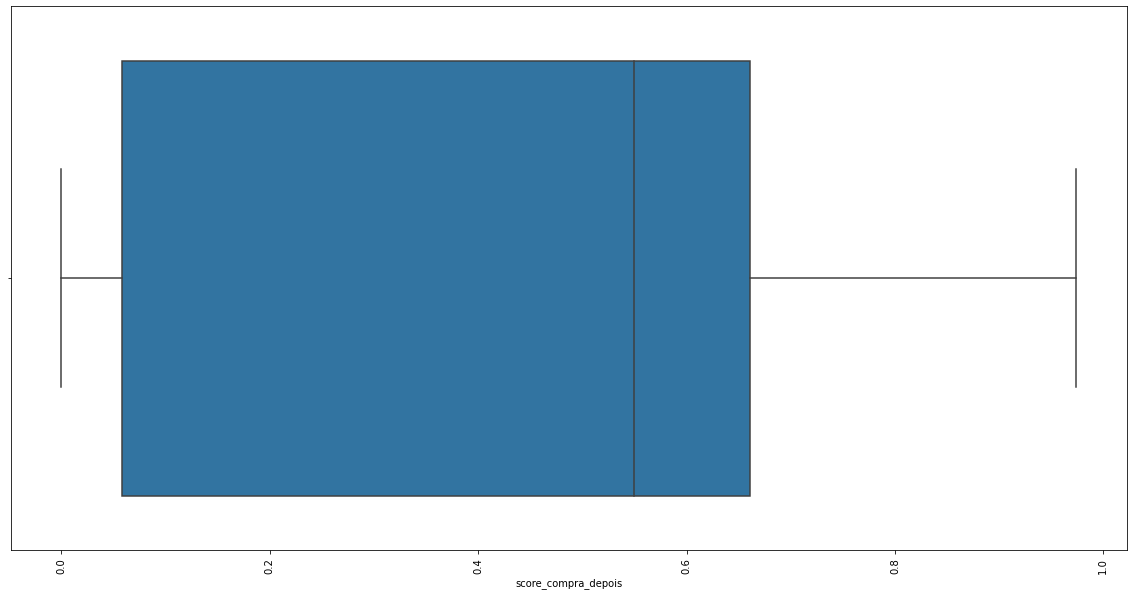

In [32]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df, x = 'score_compra_depois')
plt.xticks(rotation=90)
plt.show()

In [33]:
df['score_compra_depois'].max() - df['score_compra_depois'].min()

0.9737608797433462

In [34]:
df.teve_compra_depois.value_counts()

1    113917
0     61310
Name: teve_compra_depois, dtype: int64

In [35]:
df['fx_score'] = np.round(df['score_compra_depois'],1)
df[['teve_compra_depois', 'fx_score']].groupby('fx_score').mean()

,teve_compra_depois
fx_score,
0.0,0.005827
0.1,0.505779
0.2,0.625409
0.3,0.719213
0.4,0.782389
0.5,0.844693
0.6,0.891394
0.7,0.932833
0.8,0.952896


In [36]:
agg_df_compra_sim = df[df['teve_compra_depois'] == 1][['fx_score', 'cpf']].groupby('fx_score').count()
agg_df_compra_nao = df[df['teve_compra_depois'] == 0][['fx_score', 'cpf']].groupby('fx_score').count()

agg_df_compra = agg_df_compra_sim.join(agg_df_compra_nao, lsuffix='sim', rsuffix='nao')
agg_df_compra = agg_df_compra.reset_index()
agg_df_compra['cumperc_nao'] = agg_df_compra['cpfnao'].cumsum()/agg_df_compra['cpfnao'].sum()*100
agg_df_compra['cumperc_sim'] = agg_df_compra['cpfsim'].cumsum()/agg_df_compra['cpfsim'].sum()*100
agg_df_compra['dif'] = agg_df_compra['cumperc_nao'] - agg_df_compra['cumperc_sim']
agg_df_compra['dif_abs'] = np.abs(agg_df_compra['dif'])
# tabela de taxa de compra por fx-score para o ppt

agg_df_compra

,fx_score,cpfsim,cpfnao,cumperc_nao,cumperc_sim,dif,dif_abs
0,0.0,253,43169.0,70.411026,0.222092,70.188934,70.188934
1,0.1,2363,2309.0,74.177133,2.296409,71.880724,71.880724
2,0.2,2865,1716.0,76.976023,4.811398,72.164626,72.164626
3,0.3,4567,1783.0,79.884195,8.820457,71.063738,71.063738
4,0.4,7579,2108.0,83.322460,15.473547,67.848913,67.848913
5,0.5,16099,2960.0,88.150383,29.605766,58.544618,58.544618
6,0.6,33922,4133.0,94.891535,59.383586,35.507949,35.507949
7,0.7,37526,2702.0,99.298646,92.325114,6.973532,6.973532
8,0.8,8456,418.0,99.980427,99.748062,0.232365,0.232365
9,0.9,286,12.0,100.000000,99.999122,0.000878,0.000878


In [37]:
#qtos clientes foram escolhidos ao acaso para não ter atendimento?

print(len(df.query('usou_chat_sim == 0')))

17594


In [38]:
print(len(df.query('usou_chat_sim == 0 & teve_compra_depois == 0')))

6152


In [39]:
# diferença de score entre clientes com e sem atendimento

df.groupby('usou_chat_sim')["score_compra_depois"].mean()

usou_chat_sim
0    0.444000
1    0.426408
Name: score_compra_depois, dtype: float64

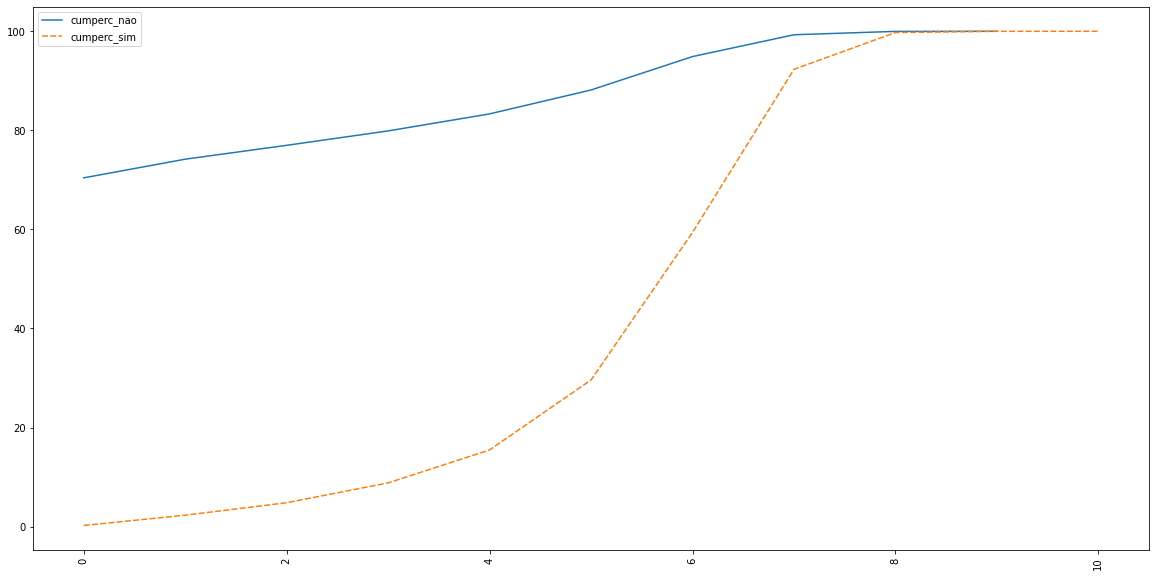

In [40]:
plt.figure(figsize = (20,10))
sns.lineplot(data = agg_df_compra[['cumperc_nao', 'cumperc_sim']])
plt.xticks(rotation=90)
plt.show()

In [41]:
dif_maxima = agg_df_compra['dif_abs'].max()

threshould_conservador = agg_df_compra[agg_df_compra.dif_abs == dif_maxima]['fx_score'].min()

print(threshould_conservador)

0.2


In [42]:
df['compra_depois_propensao']  = np.where(df['fx_score'] > threshould_conservador, 1,0)

print(len(df.query('compra_depois_propensao == 1')))
print(len(df.query('compra_depois_propensao == 0')))


122552
52675


In [43]:
#inputando spending para o cliente que teve churn de fato, que foi sorteado para não ter atendimento na simulação e com baixo score de compra depois
df['flag_atribui_spending'] = np.where((df['compra_depois_propensao'] == 1) & (df['teve_compra_depois'] == 0) & (df.usou_chat_sim == 0),1,0)

print(f"Temos {len(df.query('teve_compra_depois == 0 & usou_chat_sim == 0 & compra_depois_propensao == 0'))} clientes dentre os sorteados para não ter atendimento e não tiveram compra que tem ainda tem chance de churn (vou descartar)")

print(f"vou atribuir spending para {len(df.query('flag_atribui_spending == 1'))} clientes")

Temos 4671 clientes dentre os sorteados para não ter atendimento e não tiveram compra que tem ainda tem chance de churn (vou descartar)
vou atribuir spending para 1481 clientes


In [44]:
for column in vars_rfm:
  if df[column].dtype == 'float' or df[column].dtype == 'int':
    nm_col = column + "_fx"
    df[nm_col] = pd.qcut(df[column].rank(method='first'), q=3, precision=0, labels = ['A', 'B', 'C'])


df['segmento'] = df.cc_time_fx.astype("string") + df.dias_desde_ultima_compra_fx.astype("string") + df.qt_compra_antes_90d_fx.astype("string") + df.vl_compra_antes_90d_fx.astype("string")

df['segmento'].value_counts()

BBAA    42802
CACC    16155
ACBB     8591
AABB     7045
AACB     6398
        ...  
CACA        9
ABCA        9
BACA        6
BBCA        4
CBCA        3
Name: segmento, Length: 81, dtype: Int64

In [45]:
tabela_churn.to_csv('tabela_churn.csv', index=False)

In [46]:
df = df.join(tabela_churn.set_index('segmento'), on = 'segmento', how = 'left' )

In [47]:
df_comprou = df.query('teve_compra_depois == 1')

formula_text = ("""
vl_compra_depois_60d ~ 
C(periodo_depois30_fim) + 
qt_compra_antes_90d +  vl_current_limit + 
C(ds_gender) + C(ds_state_abbreviation) + C(ds_schooling) + 
C(ds_marital_status) + cc_time + dias_ativacao + 
C(ds_city_size) + vl_compra_antes_90d + vl_renda_declarada  + dias_uso_app
""")

model = ols(formula = formula_text, data = df_comprou).fit()
df_nao_comprou = df.query('flag_atribui_spending == 1')

print(len(df_nao_comprou))

for column in df_nao_comprou.columns:
    if df_nao_comprou[column].dtype == 'object':
        df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
    elif df_nao_comprou[column].dtype == 'string':
        pass
    elif df_nao_comprou[column].dtype == 'category':
        pass
    elif df_nao_comprou[column].dtype == 'datetime64[ns]':
        pass
    elif df_nao_comprou[column].dtype != 'object':
        df_nao_comprou[column].fillna(df_nao_comprou[column].median(), inplace = True)

prediction = model.predict(df_nao_comprou)

incremento_total = prediction.sum()

df_nao_comprou['valor incremental bruto'] = prediction
df_nao_comprou['valor incremental bruto'] = np.where(df_nao_comprou['valor incremental bruto'] >  df_nao_comprou['vl_current_limit'], df_nao_comprou['vl_current_limit'], df_nao_comprou['valor incremental bruto'])


1481


/tmp/ipykernel_1241265/585532381.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
/tmp/ipykernel_1241265/585532381.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column].fillna(df_nao_comprou[column].mode()[0], inplace = True)
/tmp/ipykernel_1241265/585532381.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou[column

In [48]:
df_nao_comprou['LTV Bruto'] = (df_nao_comprou['valor incremental bruto'] / 2) * df_nao_comprou['LT']

/tmp/ipykernel_1241265/473920939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['LTV Bruto'] = (df_nao_comprou['valor incremental bruto'] / 2) * df_nao_comprou['LT']


# Calculos para LTV LÍQUIDO

In [49]:
df_nao_comprou['Percentual ITR'] = np.where(df_nao_comprou['spending_ltv'] == 0, 0.014, df_nao_comprou['rec_itr'] / df_nao_comprou['spending_ltv'])


/tmp/ipykernel_1241265/3533183355.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['Percentual ITR'] = np.where(df_nao_comprou['spending_ltv'] == 0, 0.014, df_nao_comprou['rec_itr'] / df_nao_comprou['spending_ltv'])


In [50]:
df_nao_comprou['Percentual ITR'].describe()

count    1481.00000
mean        0.01426
std         0.00025
min         0.01400
25%         0.01400
50%         0.01450
75%         0.01450
max         0.01450
Name: Percentual ITR, dtype: float64

In [51]:
df_nao_comprou['LTV Receita Valor'] = (df_nao_comprou['Percentual ITR'] * df_nao_comprou['LTV Bruto'])
+ df_nao_comprou.rec_recarga + df_nao_comprou.rec_demais_encargos + df_nao_comprou.desp_pdd + df_nao_comprou.rec_juros + df_nao_comprou.custos


/tmp/ipykernel_1241265/197665048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nao_comprou['LTV Receita Valor'] = (df_nao_comprou['Percentual ITR'] * df_nao_comprou['LTV Bruto'])


21        -21.000000
302         1.000000
399        57.463699
543       227.218633
576        -5.317400
             ...    
175036     -6.011522
175053     -3.109170
175076      6.000000
175085     -4.934500
175093    104.272985
Length: 1481, dtype: float64

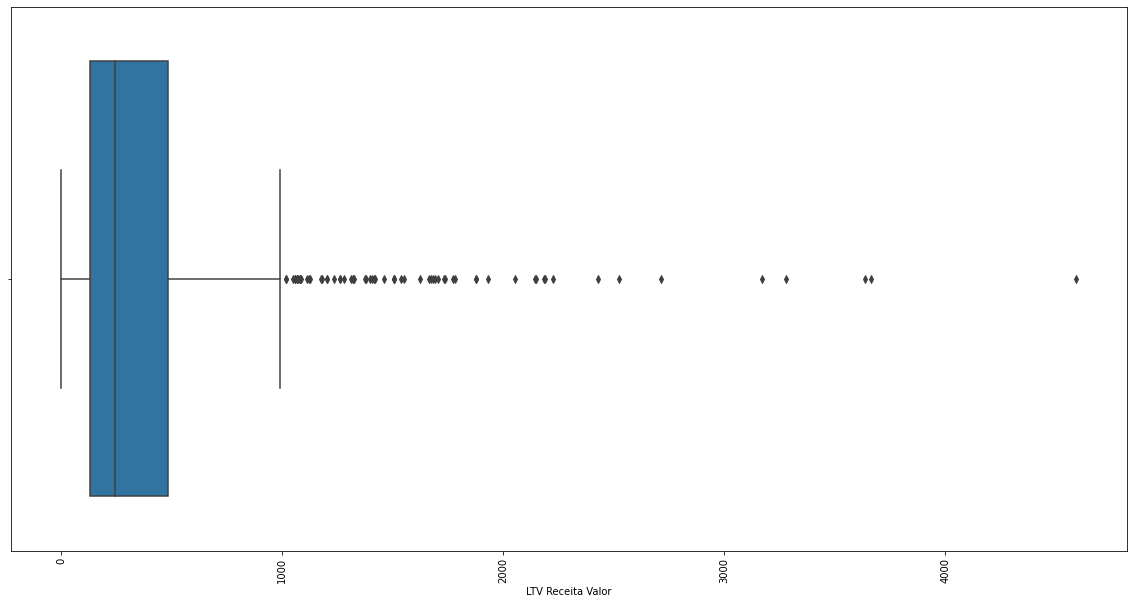

In [52]:
plt.figure(figsize = (20,10))
sns.boxplot(data = df_nao_comprou.query('dt_mes_true == "2023-01-01"'), x = 'LTV Receita Valor')
plt.xticks(rotation=90)
plt.show()

In [53]:
#incluir incremento ajustado
resultado_sim = df_nao_comprou[['hierarquia_1', 'valor incremental bruto', 'dt_mes_true', 'LTV Bruto', 'LTV Receita Valor', 'ltv']].groupby(['hierarquia_1', 'dt_mes_true']).sum()
resultado_sim = resultado_sim.reset_index()
resultado_sim

,hierarquia_1,dt_mes_true,valor incremental bruto,LTV Bruto,LTV Receita Valor,ltv
0,Assunto não identificado,2023-01-01,5143.387744,7.792212e+04,1120.195071,425.578688
1,Assunto não identificado,2023-02-01,2031.678401,3.105869e+04,440.097157,177.191200
2,Assunto não identificado,2023-03-01,9985.323702,1.717304e+05,2475.180834,847.085280
3,Atendimento,2023-01-01,10208.607435,2.234701e+05,3210.523581,324.579608
4,Atendimento,2023-02-01,25581.844483,7.517527e+05,10713.689377,230.737404
5,Atendimento,2023-03-01,5439.142181,1.074638e+05,1516.089174,138.171175
6,Cartão,2023-01-01,473764.658738,1.144253e+07,163644.468043,17219.431958
7,Cartão,2023-02-01,465333.789053,1.086787e+07,155301.124981,21223.978476
8,Cartão,2023-03-01,399623.544602,9.173910e+06,130960.075111,16798.210105
9,Conta,2023-01-01,31579.931598,6.492023e+05,9243.200350,2187.579099


In [54]:
print(len(df_nao_comprou))
print(len(df_nao_comprou['cpf'].unique()))

1481
1474


In [55]:
resultado_sim.groupby('dt_mes_true')['LTV Receita Valor'].sum()

dt_mes_true
2023-01-01    260795.791030
2023-02-01    199345.017505
2023-03-01    176450.385170
Name: LTV Receita Valor, dtype: float64

In [56]:
resultado_sim.groupby('dt_mes_true')['valor incremental bruto'].sum()

dt_mes_true
2023-01-01    764193.872647
2023-02-01    600203.422958
2023-03-01    539602.646793
Name: valor incremental bruto, dtype: float64

In [57]:
resultado_sim.groupby('dt_mes_true')['LTV Bruto'].sum()

dt_mes_true
2023-01-01    1.827275e+07
2023-02-01    1.396338e+07
2023-03-01    1.233917e+07
Name: LTV Bruto, dtype: float64

In [58]:
resultado_sim.groupby('dt_mes_true')['ltv'].sum()

dt_mes_true
2023-01-01    30737.675132
2023-02-01    25024.697174
2023-03-01    24658.992072
Name: ltv, dtype: float64

In [59]:
len(df_nao_comprou[df_nao_comprou['LTV Receita Valor'] == 0])

4